# LSTM Model Training for Stock Price Forecasting

This notebook trains an LSTM model using PyTorch to forecast close returns for all stocks in the TQBR dataset.

## Architecture
- **Modular design**: Separate classes for Dataset, Model, and Trainer for easy extension
- **Target**: Close Return (percentage change in Close price)
- **Training & Validation**: Proper train/val split with metrics tracking


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/DeepGap')

In [3]:
# Imports
import os
import glob
import warnings
from pathlib import Path
from typing import List, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0+cpu
CUDA available: False


## Configuration


In [4]:
# Configuration
class Config:
    # Data paths
    DATA_DIR = "data/tqbr"

    # Model hyperparameters
    SEQUENCE_LENGTH = 60  # Number of days to look back
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.2
    BIDIRECTIONAL = False

    # Training hyperparameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    EARLY_STOPPING_PATIENCE = 10
    VALIDATION_SPLIT = 0.2

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model save path
    MODEL_SAVE_DIR = "models"
    MODEL_NAME = "lstm_close_return_model.pth"

config = Config()
print(f"Using device: {config.DEVICE}")


Using device: cpu


## Data Loading and Preprocessing


In [5]:
def load_all_stock_data(data_dir: str) -> pd.DataFrame:
    """
    Load all CSV files from the data directory and combine them.
    Returns a DataFrame with columns: ticker, Date, Close, Close_Return
    """
    all_data = []
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

    print(f"Found {len(csv_files)} CSV files")

    for file_path in csv_files:
        ticker = Path(file_path).stem
        try:
            df = pd.read_csv(file_path)
            if 'Date' in df.columns and 'Close' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.sort_values('Date')

                # Calculate Close Return (percentage change * 100)
                df['Close_Return'] = df['Close'].pct_change() * 100

                # Add ticker column
                df['Ticker'] = ticker

                # Keep only necessary columns
                df = df[['Ticker', 'Date', 'Close', 'Close_Return']].copy()

                # Drop first row (NaN from pct_change)
                df = df.dropna().reset_index(drop=True)

                if len(df) > config.SEQUENCE_LENGTH:  # Only keep stocks with enough data
                    all_data.append(df)
        except Exception as e:
            print(f"Error loading {ticker}: {e}")
            continue

    if not all_data:
        raise ValueError("No data loaded!")

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total records: {len(combined_df)}")
    print(f"Unique tickers: {combined_df['Ticker'].nunique()}")
    print(f"Date range: {combined_df['Date'].min()} to {combined_df['Date'].max()}")

    return combined_df

# Load data
df_all = load_all_stock_data(config.DATA_DIR)
df_all.head()

Found 258 CSV files
Total records: 554141
Unique tickers: 254
Date range: 2013-03-26 00:00:00 to 2025-10-10 00:00:00


,Ticker,Date,Close,Close_Return
0,ALRS,2013-09-03,33.198,0.600000
1,ALRS,2013-09-04,33.327,0.388578
2,ALRS,2013-09-05,33.340,0.039007
3,ALRS,2013-09-06,33.061,-0.836833
4,ALRS,2013-09-09,33.299,0.719881


In [ ]:
# clip garbage
df_all['Close_Return'] = np.clip(df_all.Close_Return.to_numpy(), -20.0, 20.0)

In [ ]:
def prepare_sequences(df: pd.DataFrame, sequence_length: int, feature_cols: List[str] = ['Close_Return']) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for LSTM training.

    Args:
        df: DataFrame with Date, Ticker, and feature columns
        sequence_length: Number of time steps to use as input
        feature_cols: List of feature column names to use

    Returns:
        X: Array of shape (n_sequences, sequence_length, n_features)
        y: Array of shape (n_sequences,) - next day's Close_Return
    """
    sequences_X = []
    sequences_y = []

    # Group by ticker to create sequences per stock
    for ticker, group in df.groupby('Ticker'):
        group = group.sort_values('Date').reset_index(drop=True)

        # Extract features
        features = group[feature_cols].values

        # Create sequences
        for i in range(len(group) - sequence_length):
            seq_X = features[i:i+sequence_length]
            seq_y = features[i+sequence_length, 0]  # Target is Close_Return (first feature)

            sequences_X.append(seq_X)
            sequences_y.append(seq_y)

    X = np.array(sequences_X, dtype=np.float32)
    y = np.array(sequences_y, dtype=np.float32)

    print(f"Created {len(sequences_X)} sequences")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y

# Prepare sequences
X, y = prepare_sequences(df_all, config.SEQUENCE_LENGTH)
print(f"\nClose Return statistics:")
print(f"Mean: {y.mean():.4f}, Std: {y.std():.4f}")
print(f"Min: {y.min():.4f}, Max: {y.max():.4f}")


Created 538901 sequences
X shape: (538901, 60, 1), y shape: (538901,)

Close Return statistics:
Mean: 0.0576, Std: 3.0292
Min: -20.0000, Max: 20.0000


In [ ]:
print(X.shape)
print(y.shape)

(538901, 60, 1)
(538901,)


(array([5.3800e+02, 3.3000e+01, 3.0000e+01, 4.0000e+01, 5.6000e+01,
        4.4000e+01, 3.9000e+01, 3.8000e+01, 6.8000e+01, 5.2000e+01,
        6.3000e+01, 7.5000e+01, 8.4000e+01, 8.9000e+01, 1.0900e+02,
        1.1600e+02, 1.2500e+02, 1.4100e+02, 1.2600e+02, 1.5100e+02,
        1.8800e+02, 1.7400e+02, 2.2400e+02, 2.7400e+02, 2.7800e+02,
        3.4400e+02, 3.9400e+02, 4.7900e+02, 4.8000e+02, 6.0400e+02,
        7.2700e+02, 8.0300e+02, 1.0050e+03, 1.1370e+03, 1.2590e+03,
        1.7580e+03, 2.0560e+03, 2.5900e+03, 3.2010e+03, 4.1030e+03,
        5.4840e+03, 6.8520e+03, 9.0600e+03, 1.2099e+04, 1.6226e+04,
        2.2267e+04, 2.9261e+04, 3.9447e+04, 5.0768e+04, 4.9749e+04,
        7.6905e+04, 4.5098e+04, 3.3330e+04, 2.4999e+04, 1.8728e+04,
        1.4470e+04, 1.0785e+04, 8.3070e+03, 6.7050e+03, 5.0010e+03,
        4.2160e+03, 3.2690e+03, 2.6410e+03, 2.2730e+03, 1.7880e+03,
        1.5930e+03, 1.3400e+03, 1.1240e+03, 9.6300e+02, 8.0800e+02,
        7.2100e+02, 6.4700e+02, 5.8600e+02, 5.30

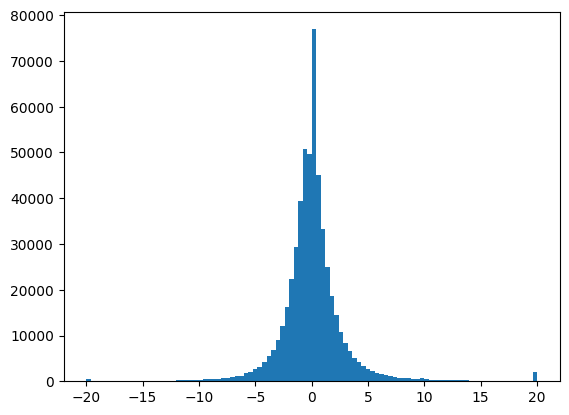

In [ ]:
# plt.xlim(-1000, 1000)
plt.hist(y[(-100.0 < y) & (y < 100.0)], bins=100)

In [ ]:
for q in (1.0, 0.999, 0.99, 0.98, 0.95, 0.001, 0.0):
  print(np.quantile(y, q))

20.0
20.0
10.63257
7.2971396
4.202061
-19.574413
-20.0


In [ ]:
# Train/Validation split
def train_val_split(X: np.ndarray, y: np.ndarray, val_split: float = 0.2, shuffle: bool = True) -> Tuple:
    """Split data into train and validation sets."""
    n_samples = len(X)
    n_val = int(n_samples * val_split)

    if shuffle:
        indices = np.random.permutation(n_samples)
        X = X[indices]
        y = y[indices]

    X_train, X_val = X[:-n_val], X[-n_val:]
    y_train, y_val = y[:-n_val], y[-n_val:]

    print(f"Train: {len(X_train)} samples, Val: {len(X_val)} samples")
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = train_val_split(X, y, config.VALIDATION_SPLIT, shuffle=True)

# # Normalize features (fit on training data only)
# scaler_X = StandardScaler()
# # Reshape for scaler: (n_samples * seq_length, n_features)
# n_train, seq_len, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(-1, n_features)
# X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
# X_train = X_train_scaled.reshape(n_train, seq_len, n_features)

# # Transform validation data
# n_val, _, _ = X_val.shape
# X_val_reshaped = X_val.reshape(-1, n_features)
# X_val_scaled = scaler_X.transform(X_val_reshaped)
# X_val = X_val_scaled.reshape(n_val, seq_len, n_features)

print(f"\nAfter normalization:")
print(f"Train X - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"Val X - Mean: {X_val.mean():.4f}, Std: {X_val.std():.4f}")


Train: 431121 samples, Val: 107780 samples

After normalization:
Train X - Mean: 0.0627, Std: 3.0848
Val X - Mean: 0.0626, Std: 3.0803


## Dataset and Model Classes (Modular Architecture)


In [ ]:
class StockSequenceDataset(Dataset):
    """
    PyTorch Dataset for stock sequences.
    Modular design allows easy extension for additional features.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Args:
            X: Input sequences of shape (n_samples, sequence_length, n_features)
            y: Target values of shape (n_samples,)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockSequenceDataset(X_train, y_train)
val_dataset = StockSequenceDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 6737, Val batches: 1685


In [ ]:
class LSTMModel(nn.Module):
    """
    LSTM model for time series forecasting.
    Modular architecture allows easy extension (e.g., attention, multiple outputs).
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float = 0.2,
        bidirectional: bool = False
    ):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Calculate LSTM output size
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # Fully connected layers
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)  # Single output for regression

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            output: Tensor of shape (batch_size, 1)
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the last output (many-to-one architecture)
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out.squeeze(-1)  # (batch_size,)

# Initialize model
n_features = X_train.shape[2]
model = LSTMModel(
    input_size=n_features,
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT,
    bidirectional=config.BIDIRECTIONAL
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized on {config.DEVICE}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Model architecture summary
print("\nModel architecture:")
print(model)


Model initialized on cuda
Total parameters: 215,809
Trainable parameters: 215,809

Model architecture:
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


## Training and Validation


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Trainer:
    """
    Modular trainer class for LSTM model.
    Handles training loop, validation, early stopping, and metrics tracking.
    Now includes checkpointing functionality.
    """
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        device: torch.device,
        model_name: str = "lstm_model",
        early_stopping_patience: int = 10
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model_name = model_name
        self.early_stopping_patience = early_stopping_patience

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None

        # Create checkpoint directory if it doesn't exist
        self.checkpoint_dir = "checkpoints"
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Path to the model checkpoint
        self.checkpoint_path = os.path.join(self.checkpoint_dir, f"{self.model_name}_best.pt")

    def train_epoch(self) -> float:
        """Train for one epoch and return average loss."""
        self.model.train()
        total_loss = 0.0
        n_batches = 0

        for batch_X, batch_y in self.train_loader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(batch_X)
            loss = self.criterion(predictions, batch_y)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        return total_loss / n_batches

    def validate(self) -> float:
        """Validate and return average loss."""
        self.model.eval()
        total_loss = 0.0
        n_batches = 0

        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)

                total_loss += loss.item()
                n_batches += 1

        return total_loss / n_batches

    def save_checkpoint(self, is_best: bool, epoch: int, val_loss: float):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

        # Save the latest checkpoint
        torch.save(checkpoint, os.path.join(self.checkpoint_dir, f"{self.model_name}_latest.pt"))

        # Save the best checkpoint if this is the best model
        if is_best:
            torch.save(checkpoint, self.checkpoint_path)
            print(f"New best model saved with validation loss: {val_loss:.6f}")

    def load_checkpoint(self):
        """Load model checkpoint if it exists."""
        if os.path.exists(self.checkpoint_path):
            print(f"Loading checkpoint from {self.checkpoint_path}")
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)

            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_losses = checkpoint.get('train_losses', [])
            self.val_losses = checkpoint.get('val_losses', [])
            self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))

            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
            print(f"Best validation loss so far: {self.best_val_loss:.6f}")
            return start_epoch
        else:
            print("No checkpoint found. Starting training from scratch.")
            return 0

    def train(self, num_epochs: int) -> dict:
        """Main training loop with early stopping and checkpointing."""
        # Try to load a checkpoint if it exists
        start_epoch = self.load_checkpoint()

        print("Starting training...")
        print(f"{'Epoch':<8} {'Train Loss':<15} {'Val Loss':<15} {'Status':<10}")
        print("-" * 50)

        for epoch in range(start_epoch, num_epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Early stopping check
            is_best = False
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                is_best = True
                status = "Improved"
            else:
                self.patience_counter += 1
                status = f"Patience {self.patience_counter}/{self.early_stopping_patience}"

            # Save checkpoint if this is the best model
            if is_best:
                self.save_checkpoint(is_best, epoch, val_loss)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"{epoch+1:<8} {train_loss:<15.6f} {val_loss:<15.6f} {status:<10}")

            if self.patience_counter >= self.early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        print(f"\nTraining completed. Best validation loss: {self.best_val_loss:.6f}")

        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.MSELoss()

# Create trainer with model name
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=config.DEVICE,
    model_name="lstm_stock_predictor",  # Specify your model name here
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE
)

# Train model
history = trainer.train(config.NUM_EPOCHS)

No checkpoint found. Starting training from scratch.
Starting training...
Epoch    Train Loss      Val Loss        Status    
--------------------------------------------------
New best model saved with validation loss: 9.096390
1        9.109687        9.096390        Improved  
New best model saved with validation loss: 9.041715
New best model saved with validation loss: 9.015354
New best model saved with validation loss: 8.979113
New best model saved with validation loss: 8.950103
5        8.917259        8.950103        Improved  
New best model saved with validation loss: 8.900312
New best model saved with validation loss: 8.856872
New best model saved with validation loss: 8.835906
New best model saved with validation loss: 8.835337
New best model saved with validation loss: 8.816216
10       8.612280        8.816216        Improved  
New best model saved with validation loss: 8.800444
15       8.268063        8.882195        Patience 3/10
20       7.955037        8.994865       

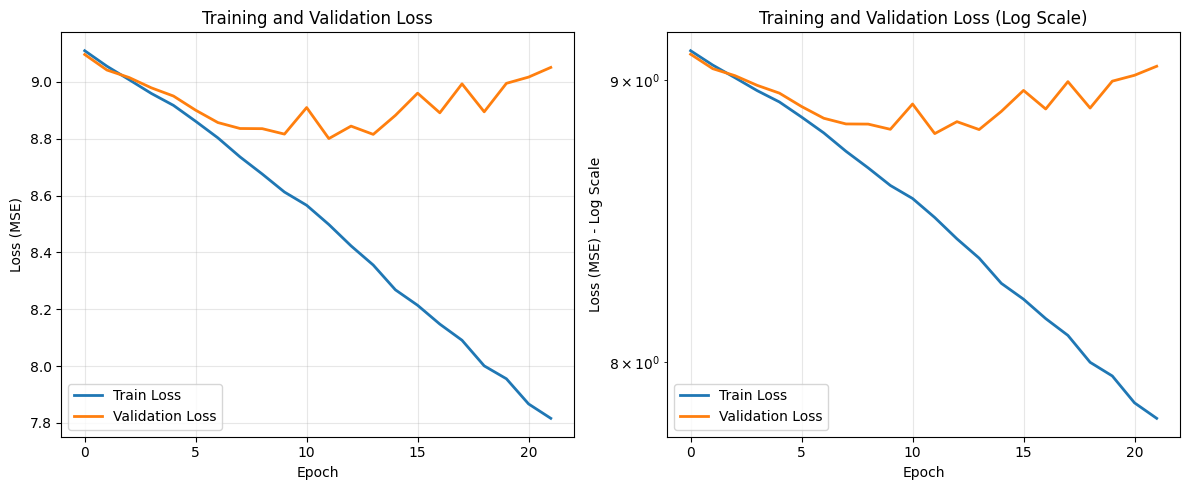

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE) - Log Scale')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Model Evaluation


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE (Mean Absolute Percentage Error)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by filtering out zero values in y_true
    mask = y_true != 0
    if np.sum(mask) == 0:
        # If all values are zero, return 0 to avoid division by zero
        return 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model: nn.Module, data_loader: DataLoader, device: torch.device) -> dict:
    """Evaluate model and return metrics."""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            predictions = model(batch_X)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    mape = mean_absolute_percentage_error(targets, predictions)

    # Calculate directional accuracy (sign prediction)
    pred_sign = np.sign(predictions)
    target_sign = np.sign(targets)
    directional_accuracy = (pred_sign == target_sign).mean() * 100

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'directional_accuracy': directional_accuracy,
        'predictions': predictions,
        'targets': targets
    }

# Evaluate on train and validation sets
print("Evaluating model...")
train_metrics = evaluate_model(model, train_loader, config.DEVICE)
val_metrics = evaluate_model(model, val_loader, config.DEVICE)

print("\n" + "="*50)
print("TRAINING SET METRICS")
print("="*50)
print(f"MSE:  {train_metrics['mse']:.6f}")
print(f"RMSE: {train_metrics['rmse']:.6f}")
print(f"MAE:  {train_metrics['mae']:.6f}")
print(f"MAPE: {train_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {train_metrics['directional_accuracy']:.2f}%")

print("\n" + "="*50)
print("VALIDATION SET METRICS")
print("="*50)
print(f"MSE:  {val_metrics['mse']:.6f}")
print(f"RMSE: {val_metrics['rmse']:.6f}")
print(f"MAE:  {val_metrics['mae']:.6f}")
print(f"MAPE: {val_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {val_metrics['directional_accuracy']:.2f}%")

Evaluating model...

TRAINING SET METRICS
MSE:  7.476176
RMSE: 2.734260
MAE:  1.689353
MAPE: 110.48%
Directional Accuracy: 51.07%

VALIDATION SET METRICS
MSE:  9.055243
RMSE: 3.009193
MAE:  1.772945
MAPE: 112.73%
Directional Accuracy: 50.13%


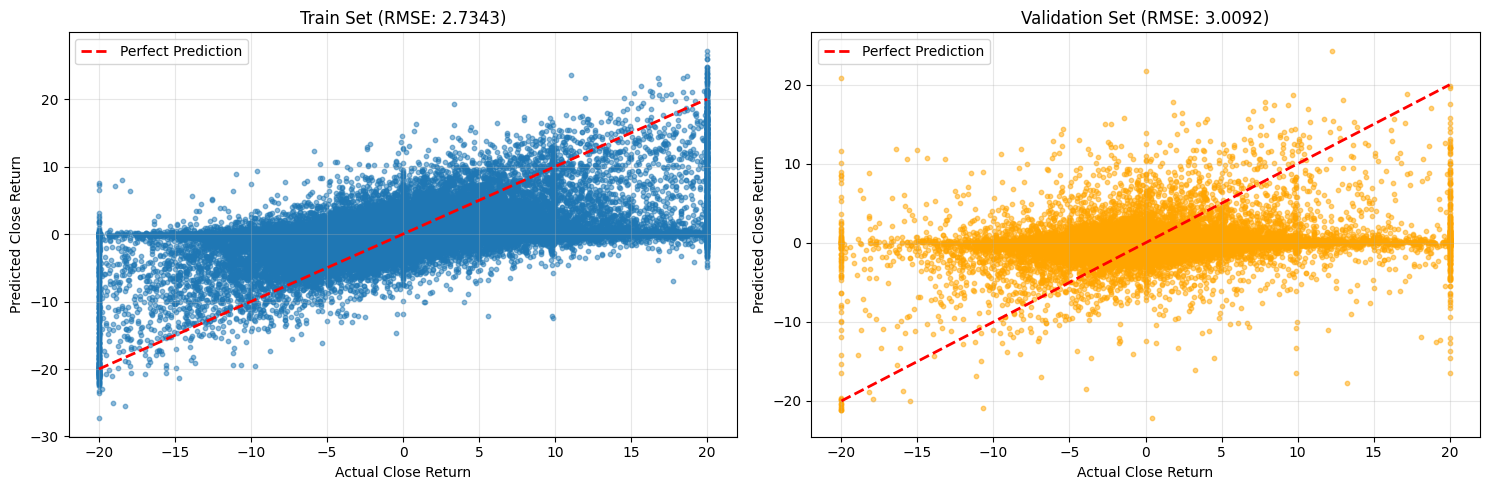

In [ ]:
# Plot predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(train_metrics['targets'], train_metrics['predictions'], alpha=0.5, s=10)
axes[0].plot([train_metrics['targets'].min(), train_metrics['targets'].max()],
              [train_metrics['targets'].min(), train_metrics['targets'].max()],
              'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Close Return')
axes[0].set_ylabel('Predicted Close Return')
axes[0].set_title(f'Train Set (RMSE: {train_metrics["rmse"]:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(val_metrics['targets'], val_metrics['predictions'], alpha=0.5, s=10, color='orange')
axes[1].plot([val_metrics['targets'].min(), val_metrics['targets'].max()],
             [val_metrics['targets'].min(), val_metrics['targets'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Close Return')
axes[1].set_ylabel('Predicted Close Return')
axes[1].set_title(f'Validation Set (RMSE: {val_metrics["rmse"]:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


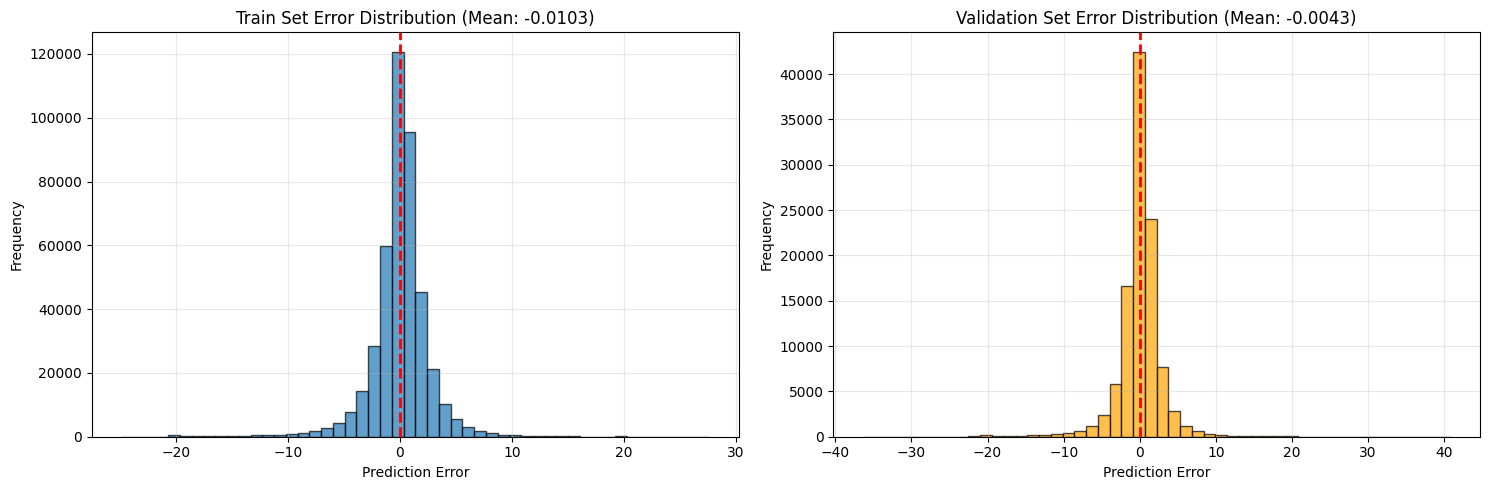

In [ ]:
# Plot error distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_errors = train_metrics['predictions'] - train_metrics['targets']
val_errors = val_metrics['predictions'] - val_metrics['targets']

axes[0].hist(train_errors, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Set Error Distribution (Mean: {train_errors.mean():.4f})')
axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(val_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Validation Set Error Distribution (Mean: {val_errors.mean():.4f})')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
